In [1]:
import os
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.core.config import Config, CONFIGURED

work_path = os.getcwd()
data_path = os.path.join(work_path.split("tvb_nest")[0], "data")
outputs_path = os.path.join(work_path, "outputs/IzhikevichExcI")
config = Config(output_base=outputs_path)

config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config)

try:
    from tvb_multiscale.core.tvb.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = None
    
# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Prepare TVB simulator <br> (including structural data -minimally a TVB connectivity, region mean field model, integrator, monitors etc)

In [2]:
from tvb_multiscale.core.tvb.cosimulator.cosimulator_builder import CoSimulatorBuilder
from tvb.datatypes.connectivity import Connectivity
from tvb_multiscale.core.tvb.cosimulator.models.izhikevich_exc_io import IzhikevichExcIO

# Using the tvb-multdiscale simulator builder with default choices...
simulator_builder = CoSimulatorBuilder()

simulator_builder.model = IzhikevichExcIO()
simulator_builder.model_params = \
    {"I_ext":   np.array([3.77,]), 
     "G":   np.array([0.0,])  # G / N_E to normalize for the order of the spiking networks
    }

simulator_builder.connectivity = Connectivity(weights=np.array([[0.0, 1.0], [1.0, 0.0]]), 
                                              tract_lengths=np.array([[0.3, 3.0], [3.0, 0.3]]), 
                                              centres=np.array([[0.0, 0.0, 0.0], [1.0, 1.0, 1.0]]), 
                                              region_labels=np.array(["Region0", "Region1"]))
# simulator_builder.connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)

simulator_builder.dt = 0.1
#                                                   S             V    U    R    I
simulator_builder.noise_strength = 0.0*np.array([config.DEFAULT_NSIG, 0.0, 0.0, 0.0, 0.0])

simulator_builder.initial_conditions = np.array([0.0, -65.0, -12.0, 0.0, 0.0])
simulator_builder.initial_conditions = simulator_builder.initial_conditions[None, :, None, None]

simulator = simulator_builder.build()

simulator.simulation_length = 1000.0

# plotter.plot_tvb_connectivity(simulator.connectivity)


2021-06-14 10:38:08,968 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Region simulation with 2 ROI nodes
2021-06-14 10:38:08,969 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Memory requirement estimate: simulation will need about 0.0 MB
2021-06-14 10:38:08,970 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Using provided initial history of shape (11, 5, 2, 1)
2021-06-14 10:38:08,972 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Final initial history shape is (11, 5, 2, 1)
2021-06-14 10:38:08,976 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Memory requirement census: simulation will need about 0.0 MB


In [3]:
state = np.array([0.0, -65.0, -12.0, 0.0, 0.0])
state = state[:, None, None]
coupling = 0.0 * state[0]
coupling = coupling[None, :]
simulator.model.update_state_variables_before_integration(state, coupling)

array([[[ 0.00000000e+00]],

       [[-6.50000000e+01]],

       [[-1.20000000e+01]],

       [[ 4.14853448e-88]],

       [[ 3.77000000e+00]]])

In [4]:
results = simulator.run()
# Gather the results
time = results[0][0]
data = results[0][1]

2021-06-14 10:38:09,002 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Simulation runtime should be about 0.657 seconds
2021-06-14 10:38:09,006 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Calculating storage requirement for ...
2021-06-14 10:38:09,009 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - Calculated storage requirement for simulation: 900000 
2021-06-14 10:38:14,689 - INFO - tvb_multiscale.core.tvb.cosimulator.cosimulator - 5.687 s elapsed, 5.687x real time


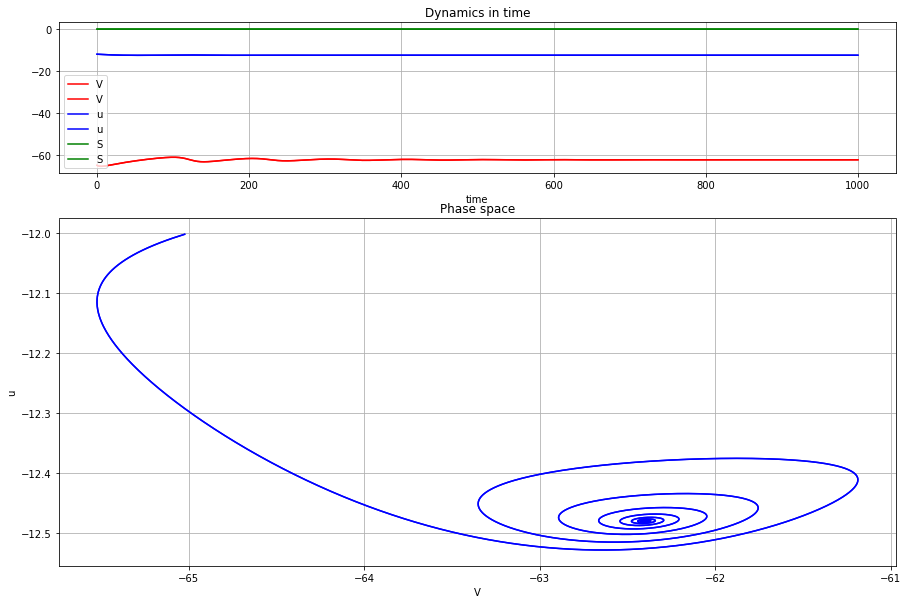

In [8]:
import matplotlib.pyplot as plt
#plot
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(wspace = 0.5, hspace = 0.3)
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,(2, 3))

ax1.plot(time, data[:, 1, :, 0], 'r-', label='V')
ax1.plot(time, data[:, 2, :, 0], 'b-', label='u')
ax1.plot(time, data[:, 3, :, 0], 'g-', label='S')
#ax1.plot(z, 'g-', label='prey')
ax1.set_title("Dynamics in time")
ax1.set_xlabel("time")
ax1.grid()
ax1.legend(loc='best')

ax2.plot(data[:, 1, :, 0], data[:, 2, :, 0], color="blue")
ax2.set_xlabel("V")
ax2.set_ylabel("u")  
ax2.set_title("Phase space")
ax2.grid()

plt.show()

In [9]:
t = results[0][0]
source = results[0][1]

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion

source_ts = TimeSeriesRegion(data, time=t,
               connectivity=simulator.connectivity,
               labels_ordering=["Time", "State Variable", "Region", "Neurons"],
               labels_dimensions=
                    {"State Variable": simulator.model.state_variables,
                     "Region": simulator.connectivity.region_labels.tolist()},
               sample_period=simulator.integrator.dt)
source_ts.configure()

writer.write_tvb_to_h5(source_ts, os.path.join(config.out.FOLDER_RES, source_ts.title.replace(" ", "_") + ".h5"))

source_ts 


,value
Dimensions,"['Time', 'State Variable', 'Region', 'Neurons']"
Length,10000
Region Mapping,None
Region Mapping Volume,None
Sample period,0.09999999999999999
Source Connectivity,Connectivity gid: e9a11897-19bb-49e3-9a5d-23f62cfa1219
Time units,ms
Time-series name,Region Time Series
Time-series type,TimeSeriesRegion
"[min, median, max]","[-65.5223, 1.57801e-65, 3.77]"


In [11]:
# Separate mean field time series into different populations
from pandas import Series

from tvb_multiscale.core.utils.computations_utils import compute_tvb_spike_rate_corrs
mean_field = source_ts
tvb_rates = source_ts[:, 3]
tvb_rates.title = "Region mean field rate time series"
    
tvb_corrs = compute_tvb_spike_rate_corrs(tvb_rates)
if writer is not None:
    writer.write_tvb_to_h5(tvb_rates, os.path.join(config.out.FOLDER_RES, tvb_rates.title.replace(" ", "_")) + ".h5",
                           recursive=False)
writer.write_object(tvb_corrs, path=os.path.join(config.out.FOLDER_RES, "TVB_corrs") + ".h5")


2021-06-14 10:46:33,920 - INFO - tvb_multiscale.core.tvb.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/notebooks/outputs/IzhikevichExcI/res/TVB_corrs.h5
2021-06-14 10:46:33,920 - INFO - tvb_multiscale.core.tvb.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/examples/notebooks/outputs/IzhikevichExcI/res/TVB_corrs.h5
2021-06-14 10:46:33,942 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-06-14 10:46:33,942 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2021-06-14 10:46:33,946 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-06-14 10:46:33,946 - WARNING - tvb_multiscale.core.tvb.io.h5_writer - 
Writing <class 'list'> data to h5 file as a numpy array dataset !

2021-06-14 10:46:33,968 - WARNING - 

(<Closed HDF5 file>,
 '/home/docker/packages/tvb-multiscale/examples/notebooks/outputs/IzhikevichExcI/res/TVB_corrs.h5')

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


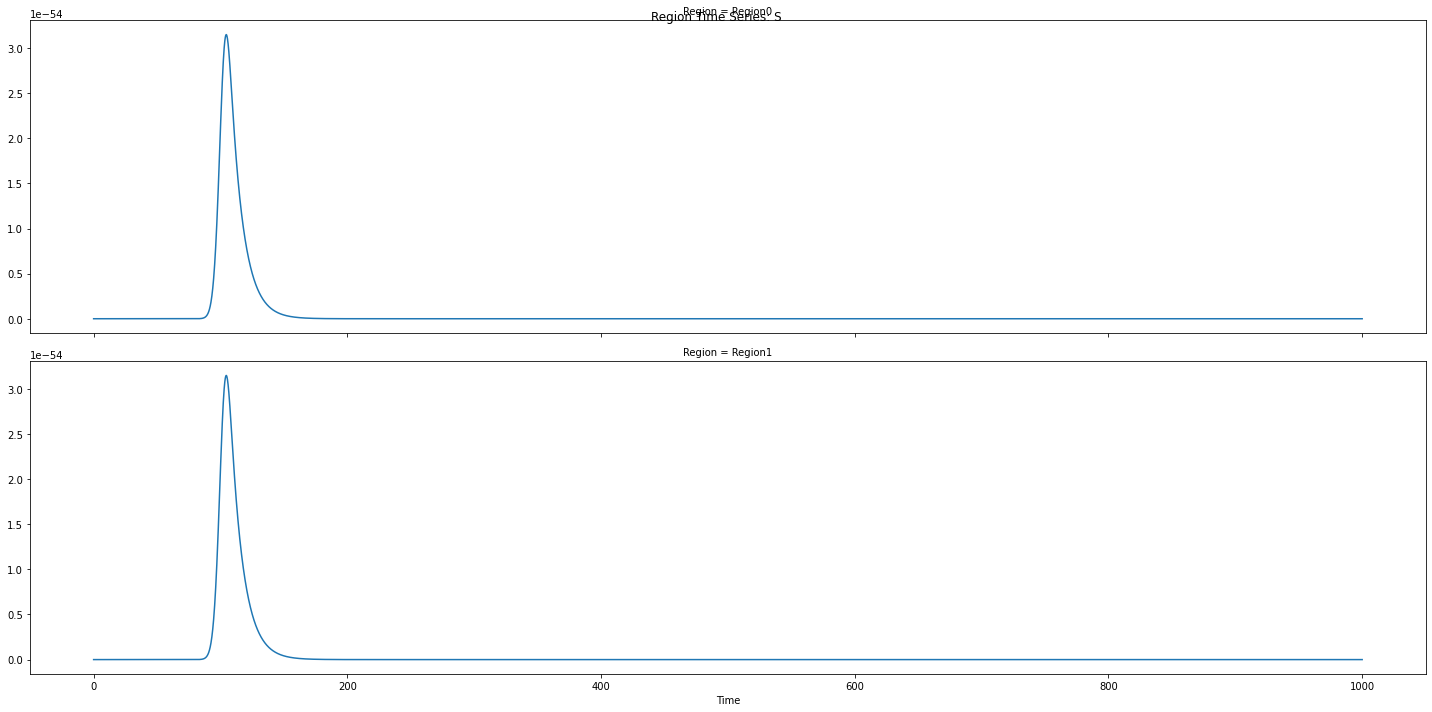

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


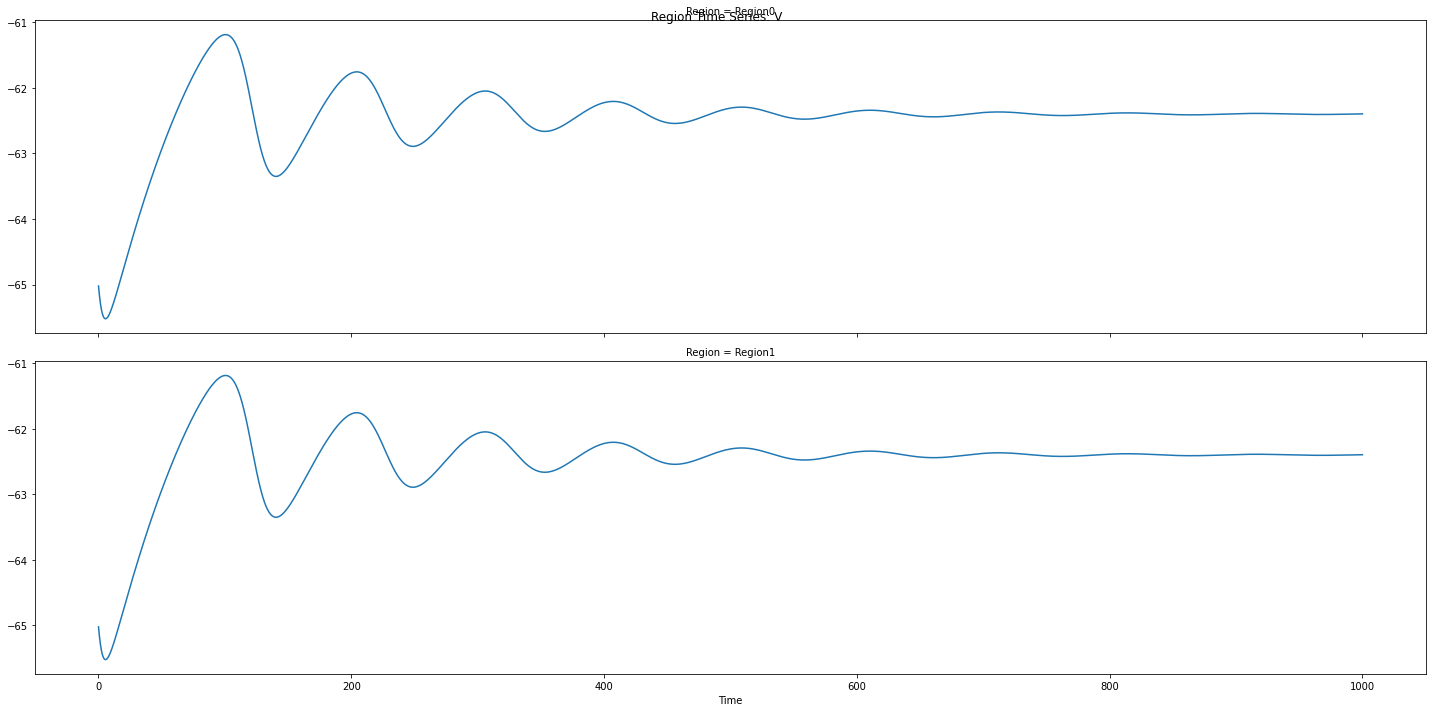

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


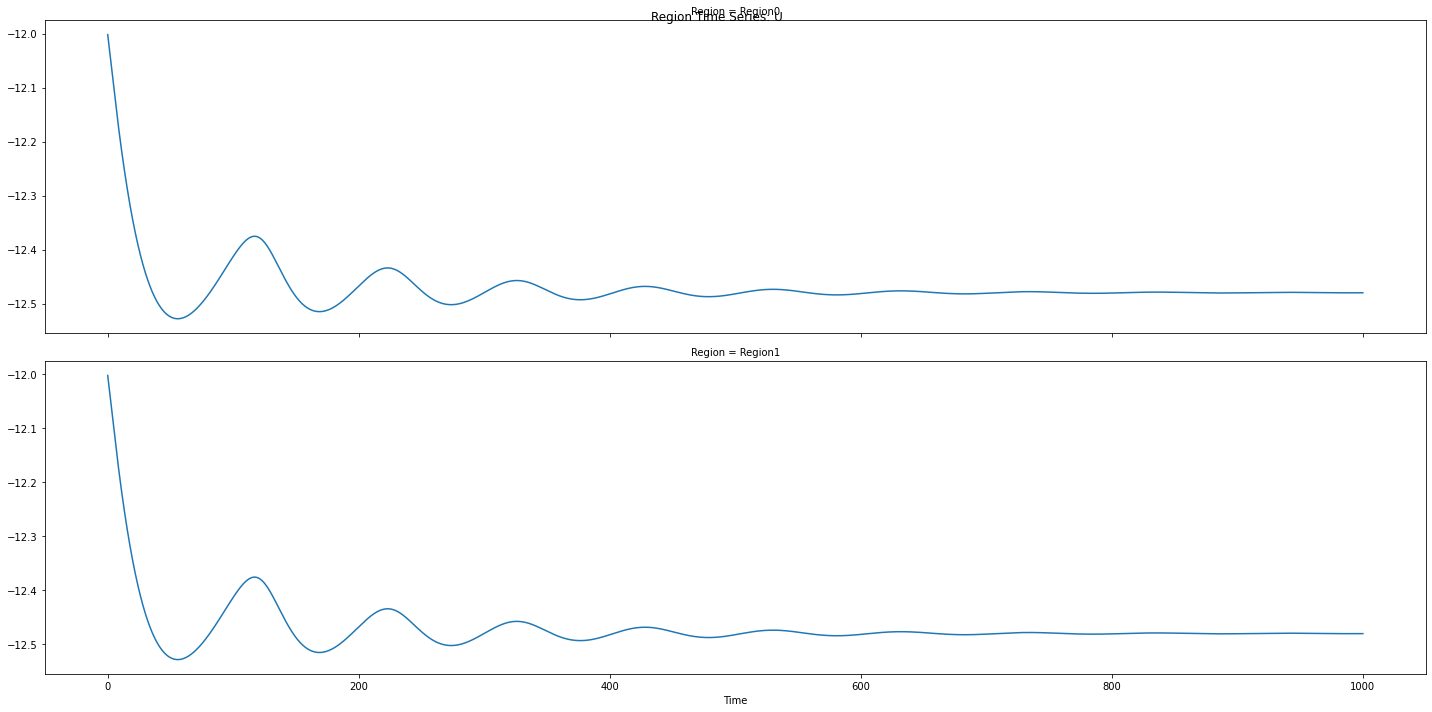

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


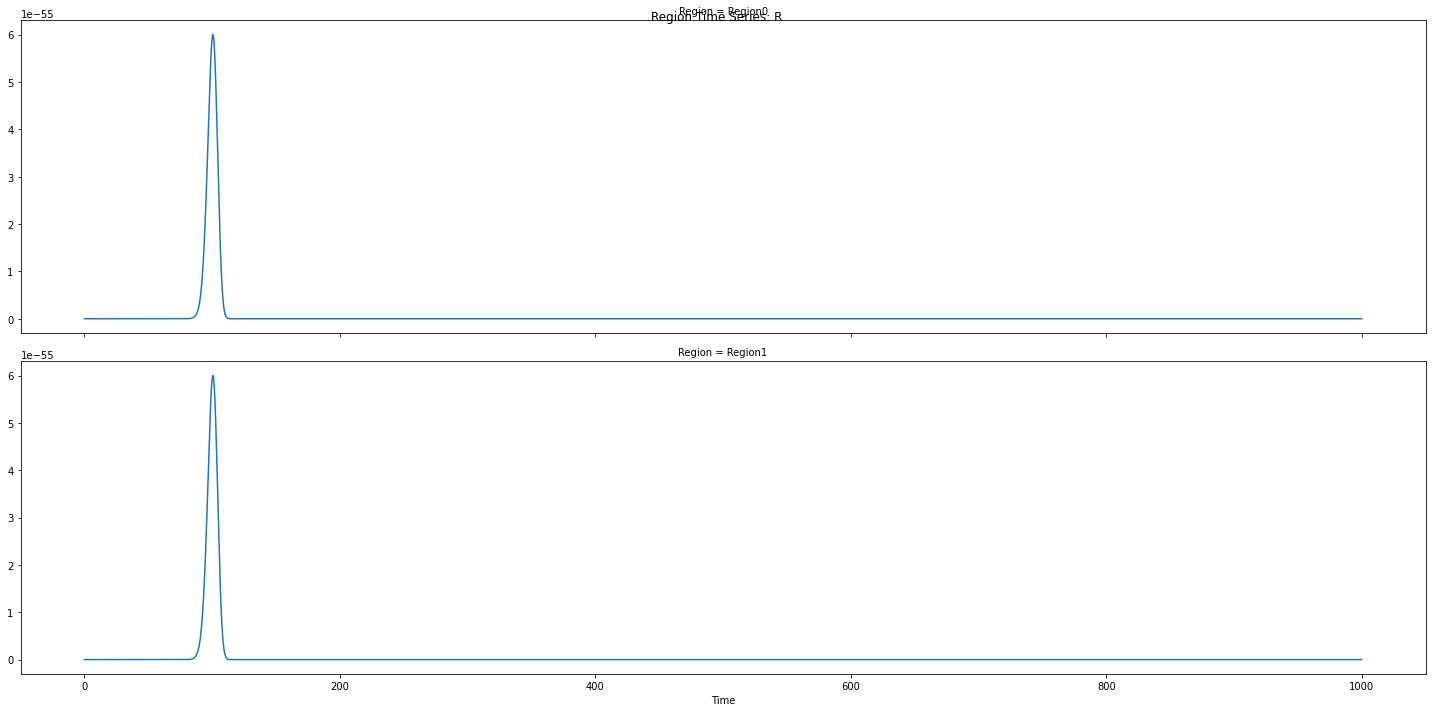

/home/docker/packages/tvb-root/tvb_contrib/tvb/contrib/scripts/datatypes/time_series_xarray.py:868: MatplotlibDeprecationWarning: 
The set_window_title function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use manager.set_window_title or GUI-specific methods instead.
  pyplot.gcf().canvas.set_window_title(figname)


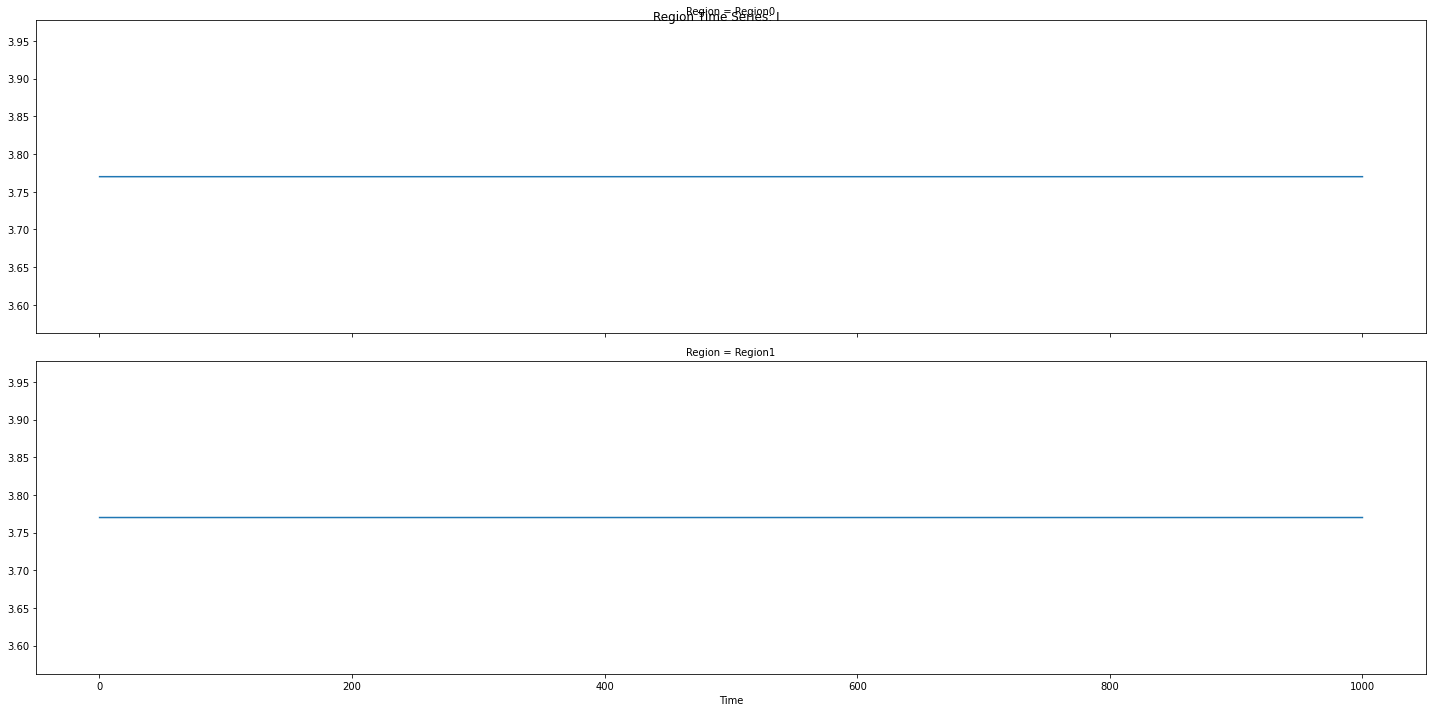

In [12]:
# For raster plot:
mean_field.plot_timeseries(plotter_config=plotter.config, per_variable=True, 
                           figsize=config.figures.NOTEBOOK_SIZE, add_legend=False)
if mean_field.number_of_labels > 9:
    mean_field.plot_raster(plotter_config=plotter.config, per_variable=True, 
                           figsize=config.figures.NOTEBOOK_SIZE, add_legend=False)

### Interactive time series plot

In [8]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)